# Synthetic Data with interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
import numpy as np
from torch.distributions import MultivariateNormal
from ignite.utils import manual_seed

In [2]:
def jordan_se2(n_samples: int = 300, n_features: int = 10, rho: float = 0.0, noise_level: float = 0.1):
    features_indices = np.arange(1, n_features+1)
    col_indices, row_indices = np.meshgrid(features_indices, features_indices)
    power_matrix = np.abs(col_indices-row_indices)
    cov = torch.Tensor(rho**power_matrix)
    loc = torch.zeros(n_features)
    normal_dist = MultivariateNormal(loc, covariance_matrix=cov)
    X = normal_dist.sample((n_samples,))
    y_noise = X[:, 0]**3 + X[:, 1]**3 + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

### SE2

In [3]:
manual_seed(1000)

In [4]:
X_se2, y_se2 = jordan_se2(rho=0.5)

#### Visualizing

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

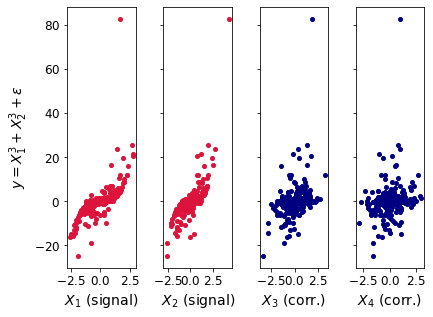

In [6]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se2[:, 0], y_se2, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_se2[:, 1], y_se2, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se2[:, i], y_se2, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Applying our method

In [7]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Define custom loss function

In [8]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

Optuna callback to save best model

In [10]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

### SE2

In [11]:
n_features = 10

In [12]:
train_size = 300
val_size = 150
test_size = 150

In [13]:
manual_seed(0)

In [14]:
X_se2, y_se2 = jordan_se2(n_samples=600, rho=0.5)

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se2, y_se2, train_size, val_size, test_size)

Generate datasets

In [16]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val, y_val)

Prepare dataloaders

In [17]:
train_loader = DataLoader(train, batch_size=train_size)
test_loader = DataLoader(test, batch_size=test_size)
val_loader = DataLoader(val, batch_size=val_size)

Objective for optuna

In [18]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 100
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 300
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [19]:
tpe_sampler = TPESampler(seed=0)

In [20]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-18 18:21:02,141] A new study created in memory with name: no-name-f0fffab2-3bb2-4566-b480-38f14857f7da


Run study

In [21]:
n_epochs = 1050

In [22]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 300 Loss: 21.14169
Validation - Epoch: 300 Loss: 24.35451
Learning rate: 0.0125
Training - Epoch: 600 Loss: 17.55644
Validation - Epoch: 600 Loss: 20.68004
Learning rate: 0.0063
Training - Epoch: 900 Loss: 16.30231
Validation - Epoch: 900 Loss: 19.31539
Learning rate: 0.0063


[I 2022-02-18 18:21:07,098] Trial 0 finished with value: 18.777333984375 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 18.777333984375.


Training - Epoch: 300 Loss: 21.27496
Validation - Epoch: 300 Loss: 23.66604
Learning rate: 0.0161
Training - Epoch: 600 Loss: 16.95417
Validation - Epoch: 600 Loss: 20.00879
Learning rate: 0.0080
Training - Epoch: 900 Loss: 15.66777
Validation - Epoch: 900 Loss: 18.97539
Learning rate: 0.0080


[I 2022-02-18 18:21:09,748] Trial 1 finished with value: 18.6020751953125 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 1 with value: 18.6020751953125.


Training - Epoch: 300 Loss: 25.80389
Validation - Epoch: 300 Loss: 27.72478
Learning rate: 0.0070
Training - Epoch: 600 Loss: 21.23096
Validation - Epoch: 600 Loss: 23.19623
Learning rate: 0.0035
Training - Epoch: 900 Loss: 19.55749
Validation - Epoch: 900 Loss: 21.50495
Learning rate: 0.0035


[I 2022-02-18 18:21:12,448] Trial 2 finished with value: 20.816453450520832 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 1 with value: 18.6020751953125.


Training - Epoch: 300 Loss: 23.42848
Validation - Epoch: 300 Loss: 25.64512
Learning rate: 0.0075
Training - Epoch: 600 Loss: 19.06873
Validation - Epoch: 600 Loss: 21.27879
Learning rate: 0.0038
Training - Epoch: 900 Loss: 17.69611
Validation - Epoch: 900 Loss: 19.87220
Learning rate: 0.0038


[I 2022-02-18 18:21:14,923] Trial 3 finished with value: 19.332887369791667 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 1 with value: 18.6020751953125.


Training - Epoch: 300 Loss: 30.96088
Validation - Epoch: 300 Loss: 34.95959
Learning rate: 0.0846
Training - Epoch: 600 Loss: 14.68040
Validation - Epoch: 600 Loss: 20.31756
Learning rate: 0.0423
Training - Epoch: 900 Loss: 14.22541
Validation - Epoch: 900 Loss: 20.38551
Learning rate: 0.0423


[I 2022-02-18 18:21:17,453] Trial 4 finished with value: 17.1291650390625 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 4 with value: 17.1291650390625.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:18,165] Trial 5 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 30.93406
Training - Epoch: 300 Loss: 20.58214
Validation - Epoch: 300 Loss: 23.39163
Learning rate: 0.0137
Training - Epoch: 600 Loss: 17.25028
Validation - Epoch: 600 Loss: 20.00798
Learning rate: 0.0068
Training - Epoch: 900 Loss: 16.29959
Validation - Epoch: 900 Loss: 18.98286
Learning rate: 0.0068


[I 2022-02-18 18:21:20,834] Trial 6 finished with value: 18.598597005208333 and parameters: {'learning_rate': 0.013680095279726922, 'reg_param': 0.004246031301768216}. Best is trial 4 with value: 17.1291650390625.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:21,634] Trial 7 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 32.86245


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:22,368] Trial 8 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 34.03991


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:23,088] Trial 9 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 21.49735
Training - Epoch: 300 Loss: 19.11858
Validation - Epoch: 300 Loss: 23.16667
Learning rate: 0.0857
Training - Epoch: 600 Loss: 9.38000
Validation - Epoch: 600 Loss: 15.83162
Learning rate: 0.0428
Training - Epoch: 900 Loss: 13.00250
Validation - Epoch: 900 Loss: 18.56632
Learning rate: 0.0428


[I 2022-02-18 18:21:25,908] Trial 10 finished with value: 13.906783854166667 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 1.8580608579177215e-06}. Best is trial 10 with value: 13.906783854166667.


Training - Epoch: 300 Loss: 16.90913
Validation - Epoch: 300 Loss: 20.44260
Learning rate: 0.0805
Training - Epoch: 600 Loss: 8.85424
Validation - Epoch: 600 Loss: 12.65495
Learning rate: 0.0402
Training - Epoch: 900 Loss: 11.85743
Validation - Epoch: 900 Loss: 16.26309
Learning rate: 0.0402


[I 2022-02-18 18:21:28,800] Trial 11 finished with value: 10.7288720703125 and parameters: {'learning_rate': 0.08045564515992583, 'reg_param': 1.5966637752164484e-06}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 17.50434
Validation - Epoch: 300 Loss: 23.90149
Learning rate: 0.0919
Training - Epoch: 600 Loss: 11.33056
Validation - Epoch: 600 Loss: 19.79416
Learning rate: 0.0460


Engine run is terminating due to exception: Trial was pruned at 900 epoch.
Engine run is terminating due to exception: Trial was pruned at 900 epoch.
[I 2022-02-18 18:21:31,580] Trial 12 pruned. Trial was pruned at 900 epoch.


Training - Epoch: 900 Loss: 12.30064
Training - Epoch: 300 Loss: 17.13055
Validation - Epoch: 300 Loss: 21.08836
Learning rate: 0.0402
Training - Epoch: 600 Loss: 13.83535
Validation - Epoch: 600 Loss: 18.40074
Learning rate: 0.0201
Training - Epoch: 900 Loss: 15.29220
Validation - Epoch: 900 Loss: 19.14673
Learning rate: 0.0201


[I 2022-02-18 18:21:34,431] Trial 13 finished with value: 17.327478841145833 and parameters: {'learning_rate': 0.04021631202623736, 'reg_param': 3.8390445686527675e-06}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:35,235] Trial 14 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 29.56011
Training - Epoch: 300 Loss: 20.61276
Validation - Epoch: 300 Loss: 23.56640
Learning rate: 0.0540
Training - Epoch: 600 Loss: 13.26214
Validation - Epoch: 600 Loss: 17.64861
Learning rate: 0.0270
Training - Epoch: 900 Loss: 12.50026
Validation - Epoch: 900 Loss: 17.18767
Learning rate: 0.0270


[I 2022-02-18 18:21:38,130] Trial 15 finished with value: 13.835940755208334 and parameters: {'learning_rate': 0.05403983398328614, 'reg_param': 9.51694947641304e-07}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:38,974] Trial 16 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 27.64304


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:39,769] Trial 17 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 33.62665
Training - Epoch: 300 Loss: 17.39148
Validation - Epoch: 300 Loss: 20.43468
Learning rate: 0.0231
Training - Epoch: 600 Loss: 14.61398
Validation - Epoch: 600 Loss: 17.68298
Learning rate: 0.0116
Training - Epoch: 900 Loss: 13.03458
Validation - Epoch: 900 Loss: 16.41138
Learning rate: 0.0116


[I 2022-02-18 18:21:42,435] Trial 18 finished with value: 16.808658854166666 and parameters: {'learning_rate': 0.02310913459432815, 'reg_param': 1.163582414256726e-05}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:43,214] Trial 19 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 26.89860
Training - Epoch: 300 Loss: 20.18393
Validation - Epoch: 300 Loss: 23.48891
Learning rate: 0.0557
Training - Epoch: 600 Loss: 13.03838
Validation - Epoch: 600 Loss: 17.76850
Learning rate: 0.0278
Training - Epoch: 900 Loss: 15.19867
Validation - Epoch: 900 Loss: 19.15641
Learning rate: 0.0278


[I 2022-02-18 18:21:45,948] Trial 20 finished with value: 14.210162760416667 and parameters: {'learning_rate': 0.05565136050495805, 'reg_param': 4.573386304123305e-06}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 15.55619
Validation - Epoch: 300 Loss: 19.28790
Learning rate: 0.0957
Training - Epoch: 600 Loss: 15.10287
Validation - Epoch: 600 Loss: 18.97726
Learning rate: 0.0479
Training - Epoch: 900 Loss: 14.30706
Validation - Epoch: 900 Loss: 18.82757
Learning rate: 0.0479


[I 2022-02-18 18:21:48,636] Trial 21 finished with value: 13.161927897135417 and parameters: {'learning_rate': 0.09573869690729338, 'reg_param': 1.6556428569507777e-06}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 19.49308
Validation - Epoch: 300 Loss: 23.16445
Learning rate: 0.0629
Training - Epoch: 600 Loss: 12.10360
Validation - Epoch: 600 Loss: 17.14098
Learning rate: 0.0314
Training - Epoch: 900 Loss: 14.43768
Validation - Epoch: 900 Loss: 19.47608
Learning rate: 0.0314


[I 2022-02-18 18:21:51,338] Trial 22 finished with value: 14.414718424479167 and parameters: {'learning_rate': 0.06285951030055378, 'reg_param': 1.9924906467250075e-05}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 17.82754
Validation - Epoch: 300 Loss: 20.12463
Learning rate: 0.0254
Training - Epoch: 600 Loss: 14.91991
Validation - Epoch: 600 Loss: 17.92127
Learning rate: 0.0127
Training - Epoch: 900 Loss: 13.73330
Validation - Epoch: 900 Loss: 16.92166
Learning rate: 0.0127


[I 2022-02-18 18:21:54,088] Trial 23 finished with value: 16.6054150390625 and parameters: {'learning_rate': 0.025372089029500687, 'reg_param': 2.5676072427299882e-06}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 19.10505
Validation - Epoch: 300 Loss: 21.87667
Learning rate: 0.0662
Training - Epoch: 600 Loss: 12.39858
Validation - Epoch: 600 Loss: 15.72152
Learning rate: 0.0331
Training - Epoch: 900 Loss: 17.00820
Validation - Epoch: 900 Loss: 20.77690
Learning rate: 0.0331


[I 2022-02-18 18:21:56,807] Trial 24 finished with value: 13.1540576171875 and parameters: {'learning_rate': 0.06624188374416148, 'reg_param': 5.088419739630533e-07}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 16.23044
Validation - Epoch: 300 Loss: 20.51860
Learning rate: 0.0949


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-18 18:21:58,378] Trial 25 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 14.29111
Training - Epoch: 300 Loss: 19.71801
Validation - Epoch: 300 Loss: 22.29411
Learning rate: 0.0334


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-18 18:21:59,877] Trial 26 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 14.44029
Training - Epoch: 300 Loss: 14.10343
Validation - Epoch: 300 Loss: 22.14778
Learning rate: 0.0690
Training - Epoch: 600 Loss: 8.30896
Validation - Epoch: 600 Loss: 17.22842
Learning rate: 0.0345
Training - Epoch: 900 Loss: 6.19473
Validation - Epoch: 900 Loss: 15.54205
Learning rate: 0.0345


[I 2022-02-18 18:22:02,623] Trial 27 finished with value: 15.122701822916667 and parameters: {'learning_rate': 0.06895128524055091, 'reg_param': 6.259433993848084e-06}. Best is trial 11 with value: 10.7288720703125.


Training - Epoch: 300 Loss: 16.70359
Validation - Epoch: 300 Loss: 19.95364
Learning rate: 0.0466
Training - Epoch: 600 Loss: 12.66548
Validation - Epoch: 600 Loss: 17.71998
Learning rate: 0.0233
Training - Epoch: 900 Loss: 13.69347
Validation - Epoch: 900 Loss: 18.51055
Learning rate: 0.0233


[I 2022-02-18 18:22:05,275] Trial 28 finished with value: 15.830817057291666 and parameters: {'learning_rate': 0.04660383637790137, 'reg_param': 2.0876839110833088e-06}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:06,057] Trial 29 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 21.05977


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:06,885] Trial 30 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 20.52725


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:07,636] Trial 31 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 36.06512
Training - Epoch: 300 Loss: 20.15093
Validation - Epoch: 300 Loss: 21.04486
Learning rate: 0.0479
Training - Epoch: 600 Loss: 13.19059
Validation - Epoch: 600 Loss: 16.66573
Learning rate: 0.0240
Training - Epoch: 900 Loss: 14.59044
Validation - Epoch: 900 Loss: 18.45909
Learning rate: 0.0240


[I 2022-02-18 18:22:10,291] Trial 32 finished with value: 15.387939453125 and parameters: {'learning_rate': 0.04791356822428226, 'reg_param': 1.7608287735575138e-07}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:10,969] Trial 33 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 21.00295


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:11,681] Trial 34 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 21.16289


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:12,390] Trial 35 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 22.03627


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:13,111] Trial 36 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 23.48078
Training - Epoch: 300 Loss: 19.33396
Validation - Epoch: 300 Loss: 22.06301
Learning rate: 0.0763
Training - Epoch: 600 Loss: 11.30974
Validation - Epoch: 600 Loss: 15.87106
Learning rate: 0.0381
Training - Epoch: 900 Loss: 10.50083
Validation - Epoch: 900 Loss: 15.27183
Learning rate: 0.0381


[I 2022-02-18 18:22:15,429] Trial 37 finished with value: 13.363271484375 and parameters: {'learning_rate': 0.07628289752810442, 'reg_param': 2.8375461272717385e-05}. Best is trial 11 with value: 10.7288720703125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:16,066] Trial 38 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 23.81200


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:16,746] Trial 39 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 20.10966


Get best model

In [23]:
best_model = study.user_attrs['best_model']

In [24]:
torch.save(best_model.state_dict(), '../models/jordan-se2.pth')

Replicate best_model on different datasets

In [25]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se2(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [26]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-18 18:22:16,796] A new study created in memory with name: no-name-f8cabe30-8b3d-4bae-99f2-baf11eded650


In [27]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-18 18:22:16,811] Trial 0 finished with value: 3.34095629008996 and parameters: {}. Best is trial 0 with value: 3.34095629008996.
[I 2022-02-18 18:22:16,815] Trial 1 finished with value: 3.3383343019323775 and parameters: {}. Best is trial 1 with value: 3.3383343019323775.
[I 2022-02-18 18:22:16,818] Trial 2 finished with value: 3.688819943847219 and parameters: {}. Best is trial 1 with value: 3.3383343019323775.
[I 2022-02-18 18:22:16,822] Trial 3 finished with value: 2.8099984534860067 and parameters: {}. Best is trial 3 with value: 2.8099984534860067.
[I 2022-02-18 18:22:16,826] Trial 4 finished with value: 3.9254768486877274 and parameters: {}. Best is trial 3 with value: 2.8099984534860067.
[I 2022-02-18 18:22:16,829] Trial 5 finished with value: 2.1642879320007693 and parameters: {}. Best is trial 5 with value: 2.1642879320007693.
[I 2022-02-18 18:22:16,832] Trial 6 finished with value: 3.570404129021146 and parameters: {}. Best is trial 5 with value: 2.1642879320007693

In [28]:
replication.trials_dataframe()['value'].mean()

3.6278341989120633

In [29]:
replication.trials_dataframe()['value'].std()

1.3455456965309731

#### Visualizing

##### Bands

In [30]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

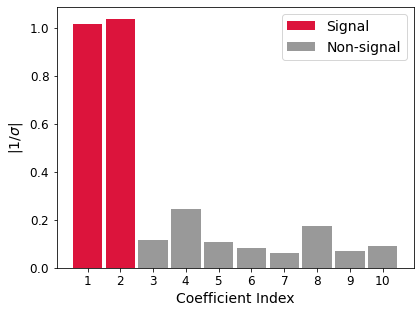

In [31]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

##### Predictions on test

In [32]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=100)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

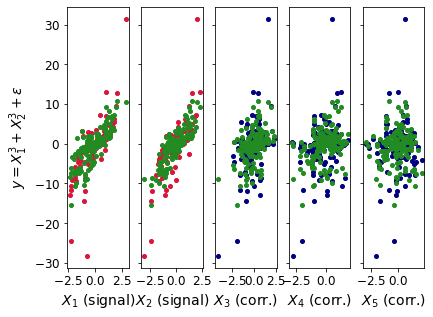

In [33]:
fig, ax = plt.subplots(ncols=5, sharey=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [34]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

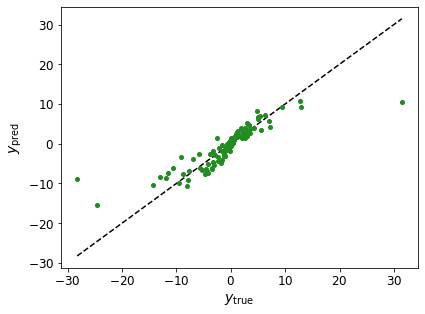

In [35]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()